# Training VGG-16 Model

Note: All training done on Kaggle website. The Stanford Dogs Dataset and each of the .h5 files can be found under "Data" on Kaggle to load initial weights for training.

Also, the architecture per model is the exact same. That is, apart from loading the preloaded weights each of them using the same data augmentation for training, image size, batch size, etc., so please refer to the documentation in the cell below for a look at how all of them work.

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

data_dir = '../input/stanford-dogs-dataset/images/Images'
class_names = sorted([folder for folder in os.listdir(data_dir)])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(160, 160),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

val_generator = val_datagen.flow_from_directory(data_dir,
                                                target_size=(160, 160),
                                                batch_size=16,
                                                class_mode='categorical',
                                                subset='validation')

num_classes = len(class_names)
img_width, img_height = 160, 160
epochs = 100
learning_rate = 0.001

base_model = VGG16(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
base_model.load_weights('../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

from tensorflow.keras.callbacks import ModelCheckpoint

# Configure the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_weights_vgg.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

# Add the checkpoint callback to your callbacks list
callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model with the callbacks
vgg_history = vgg_model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Epoch 1/100
516/516 [==============================] - 263s 495ms/step - loss: 4.4894 - accuracy: 0.0476 - val_loss: 3.9831 - val_accuracy: 0.1189 - lr: 0.0010
Epoch 2/100
516/516 [==============================] - 172s 333ms/step - loss: 3.8051 - accuracy: 0.1278 - val_loss: 3.5744 - val_accuracy: 0.1547 - lr: 0.0010
Epoch 3/100
516/516 [==============================] - 172s 332ms/step - loss: 3.5022 - accuracy: 0.1730 - val_loss: 3.4116 - val_accuracy: 0.1766 - lr: 0.0010
Epoch 4/100
516/516 [==============================] - 175s 338ms/step - loss: 3.3281 - accuracy: 0.2010 - val_loss: 3.3087 - val_accuracy: 0.2028 - lr: 0.0010
Epoch 5/100
516/516 [==============================] - 173s 335ms/step - loss: 3.2201 - accuracy: 0.2214 - val_loss: 3.2159 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 6/100
516/516 [==============================] - 174s 337ms/step - loss: 3.1379 - accuracy: 0.2341 - val_

## VGG-16: Visualization of Training (Accuracy and Loss)

This is also where the weights are saved. Again, when running on Kaggle these will be saved to output for download and later use in "Ensemble Evaluation" in this directory on GitHub.

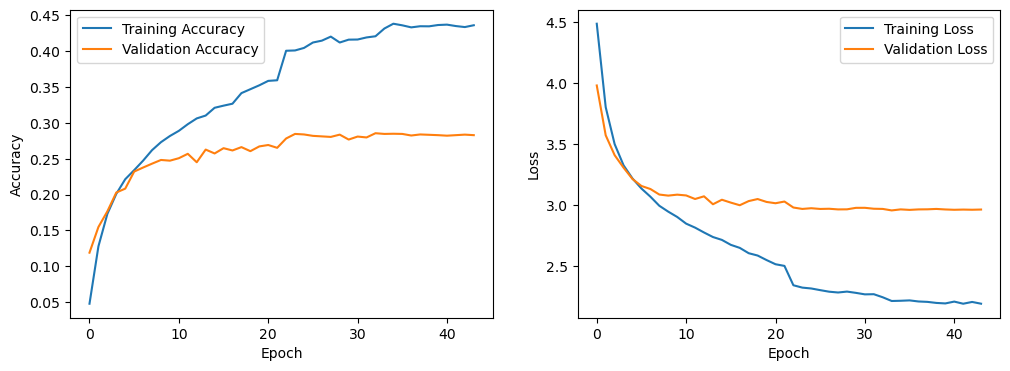

In [2]:
vgg_model.save_weights('dog_breed_classifier_vgg.h5')

import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(vgg_history)

# Training Inception v3 Model

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

inc_model = Model(inputs=inception_model.input, outputs=predictions)

for layer in inception_model.layers[:249]:
   layer.trainable = False
for layer in inception_model.layers[249:]:
   layer.trainable = True

inc_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configure the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_weights_inc.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

# Add the checkpoint callback to your callbacks list
callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model with the callbacks
inc_history = inc_model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/100
516/516 [==============================] - 189s 345ms/step - loss: 2.5879 - accuracy: 0.3432 - val_loss: 2.0092 - val_accuracy: 0.4752 - lr: 0.0010
Epoch 2/100
516/516 [==============================] - 178s 345ms/step - loss: 1.8775 - accuracy: 0.4776 - val_loss: 1.7242 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 3/100
516/516 [==============================] - 176s 342ms/step - loss: 1.6568 - accuracy: 0.5320 - val_loss: 1.6203 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 4/100
516/516 [==============================] - 178s 344ms/step - loss: 1.5052 - accuracy: 0.5649 - val_loss: 1.6867 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 5/100
516/516 [==============================] - 179s 347ms/step - loss: 1.3888 - accuracy: 0.5933 - val_loss: 1.5521 - val_accuracy: 0.5742 - lr: 0.0010
Epoch 6/100
516/516 [==============================] - 182s 352ms/step - loss: 1.3076 - accuracy: 0.6211 - val_loss: 1.5662 - val_accur

## Inception v3: Visualization of Training (Accuracy and Loss)

This is also where the weights are saved. Again, when running on Kaggle these will be saved to output for download and later use in  "Ensemble Evaluation" in this directory on GitHub.

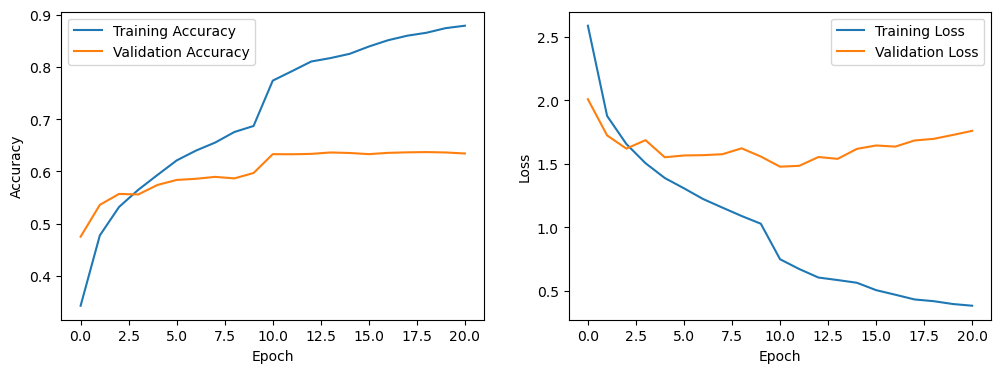

In [4]:
inc_model.save_weights('dog_breed_classifier_inc.h5')

plot_history(inc_history)

# Training Inception v3 Model

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

mn_model = Model(inputs=mobilenet_model.input, outputs=predictions)

for layer in mobilenet_model.layers[:249]:
   layer.trainable = False
for layer in mobilenet_model.layers[249:]:
   layer.trainable = True

mn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configure the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_weights_mn.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

# Add the checkpoint callback to your callbacks list
callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model with the callbacks
mn_history = mn_model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/100
516/516 [==============================] - 176s 335ms/step - loss: 1.8432 - accuracy: 0.5130 - val_loss: 1.2330 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 2/100
516/516 [==============================] - 169s 327ms/step - loss: 1.2552 - accuracy: 0.6319 - val_loss: 1.1251 - val_accuracy: 0.6631 - lr: 0.0010
Epoch 3/100
516/516 [==============================] - 167s 323ms/step - loss: 1.1092 - accuracy: 0.6716 - val_loss: 1.1234 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 4/100
516/516 [==============================] - 169s 327ms/step - loss: 0.9997 - accuracy: 0.6984 - val_loss: 1.1060 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 5/100
516/516 [==============================] - 166s 321ms/step - loss: 0.9175 - accuracy: 0.7189 - val_loss: 1.1848 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 6/100
516/516 [==============================] - 168s 324ms/step - loss: 0.8453 - accuracy: 0.7407 - val_loss: 1.1920 - val_accurac

## MobileNet v2: Visualization of Training (Accuracy and Loss)

This is also where the weights are saved. Again, when running on Kaggle these will be saved to output for download and later use in "Ensemble Evaluation" in this directory on GitHub.

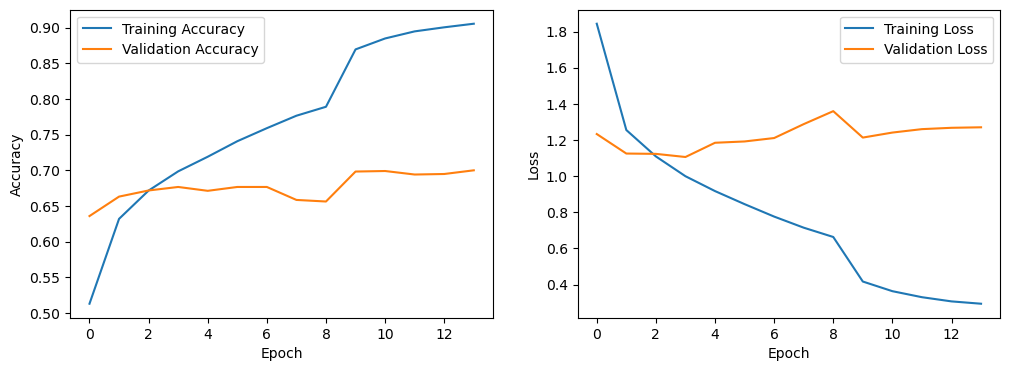

In [6]:
mn_model.save_weights('dog_breed_classifier_mn.h5')

plot_history(mn_history)